<a href="https://colab.research.google.com/github/prakritipaul/mhcglobe/blob/main/prakriti_MHCGlobe_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adapted MHCGlobe Pipeline

In [1]:
!git clone https://github.com/prakritipaul/mhcglobe.git

Cloning into 'mhcglobe'...
remote: Enumerating objects: 704, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 704 (delta 88), reused 64 (delta 25), pack-reused 549
Receiving objects: 100% (704/704), 112.55 MiB | 20.23 MiB/s, done.
Resolving deltas: 100% (386/386), done.
Updating files: 100% (197/197), done.
Error downloading object: data/distB62_unique_pseudpsequences.pkl (d151a08): Smudge error: Error downloading data/distB62_unique_pseudpsequences.pkl (d151a0800777499690d258210735bbe1bf8f627fedc59b579281582b6a03b3da): batch response: This repository is over its data quota. Account responsible for LFS bandwidth should purchase more data packs to restore access.

Errors logged to /content/mhcglobe/.git/lfs/logs/20240322T223149.747812227.log
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-process' failed
fatal: data/distB62_unique_pseudpsequences.pkl: smudge filter lfs failed
You can in

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sys
sys.path.append("/content/mhcglobe/src")

## 1. Make your dataset. Make a one-hot version and a BERT version of X (aka inputs). Y (outputs) is the same.

Starting with one-hot.

### Get data
Contains both BA+EL, human and non-human

In [3]:
import mhc_data
# 729,538/1,229,838
pMHC_true = mhc_data.pMHC_Data(only_EL=False, drop_duplicate_records=True)
pMHC_true_data = pMHC_true.data
# pMHC_true_data.shape

#### Subset only for human data + get 4 relevant columns

In [ ]:
# 678,024/729,538
human_pMHC_true_data = pMHC_true_data[pMHC_true_data["allele"].str.contains("HLA")]
# human_pMHC_true_data.shape

In [5]:
human_pMHC_true_data = human_pMHC_true_data[["allele", "peptide", "measurement_inequality", "measurement_value"]]

,allele,peptide,measurement_inequality,measurement_value
0,HLA-A*03:01,EVMPVSMAK,=,340.633333
1,HLA-A*11:01,EVMPVSMAK,=,17.140000
2,HLA-A*03:01,KTFPPTEPK,=,219.816667
3,HLA-A*11:01,KTFPPTEPK,=,222.213333
4,HLA-A*03:01,RLYYDSMSY,=,57.250000
...,...,...,...,...
1229823,HLA-B*44:02,AETEKQVAL,<,100.000000
1229825,HLA-A*02:01,NIFIGIVGV,<,100.000000
1229831,HLA-A*02:01,SMMKNFFFV,<,100.000000
1229834,HLA-B*44:02,EEQRAQQQL,<,100.000000


### Select 80% for training & 20% for testing

In [23]:
# 542419
human_pMHC_true_data_train = human_pMHC_true_data.sample(frac=0.8, random_state=1)
# 135605
human_pMHC_true_data_test = human_pMHC_true_data[~human_pMHC_true_data.index.isin(human_pMHC_true_data_train.index)]
print(human_pMHC_true_data_train.shape, human_pMHC_true_data_test.shape)

(542419, 4) (135605, 4)


#### Reset indices to prevent downstream issues!

In [24]:
human_pMHC_true_data_train = human_pMHC_true_data_train.reset_index(drop=True)
human_pMHC_true_data_test = human_pMHC_true_data_test.reset_index(drop=True)

### Make X_tr, Y_tr, X_es, Y_es for training

In [25]:
import mhcglobe
# loads the init model
ensemble = mhcglobe.ensemble(train_type="init")
# has nothing to do with the ensemble
setup_data_training = ensemble.setup_data_training(human_pMHC_true_data_train)
X_tr, Y_tr, X_es, Y_es = setup_data_training

## 2. Load one of my base tensorflow models and train.

In [26]:
import train_functions as trainf
model_dir = "/content/mhcglobe/model/mhcglobe/init/model14_fold13_ONE_HOT_init/"
model_1 = trainf.load_trained_mhcglobe_model(model_path=model_dir)

In [27]:
new_model_path, verbose = "/content/mhcglobe/outputs", 0
init_model = model_1
new_model = trainf.train_mhcglobe_model(init_model, X_tr, Y_tr, X_es, Y_es, new_model_path, verbose)

## 3. Ensure that model can predict with one-hot input.

In [28]:
import sequence_functions as seqf
import binding_affinity as ba

# Run the prediction
# to_predict = human_pMHC_true_data_test[["allele", "peptide", "measurement_inequality"]].iloc[:10]
to_predict = human_pMHC_true_data_test[["allele", "peptide", "measurement_inequality"]]

X = seqf.get_XY(to_predict, encode_type="ONE_HOT", get_Y=False)
mhcglobe_scores = new_model.predict(X)

# Get them
mhcglobe_scores = mhcglobe_scores.flatten()
mhcglobe_affinities = list(map(ba.to_ic50, mhcglobe_scores))

4238/4238 [==============================] - 7s 2ms/step


In [ ]:
# Make a df.
prediction_dict = {"mhcglobe_scores": mhcglobe_scores, "mhcglobe_affinities": mhcglobe_affinities}
prediction_df = pd.DataFrame(prediction_dict)
prediction_df

In [32]:
# Munge to_predict so I can correctly concatenate the columns
munged_to_predict = to_predict
munged_to_predict.index = prediction_df.index


In [33]:
# Present the data nicely!
prediction_df_all = pd.concat([munged_to_predict, prediction_df], axis=1)

,allele,peptide,measurement_inequality,mhcglobe_scores,mhcglobe_affinities
0,HLA-A*11:01,RLYYDSMSY,=,0.411455,582.846450
1,HLA-A*03:01,VVYRGTTTY,=,0.379144,826.764270
2,HLA-A*11:01,ITCVVIPSK,=,0.566832,108.503626
3,HLA-B*35:01,LPFDKPTIM,=,0.531161,159.609269
4,HLA-A*02:01,SLENFRAYV,=,0.507568,206.026417
...,...,...,...,...,...
135600,HLA-B*44:02,TEIPTAITI,<,0.520618,178.896489
135601,HLA-B*44:02,AETSEPVVY,<,0.577530,96.644177
135602,HLA-C*05:01,ITSPSTPSK,<,0.459684,345.882293
135603,HLA-B*44:02,AETEKQVAL,<,0.526069,168.651257


### Compare predictions with true values

In [34]:
# Get the measurement_value column of human_pMHC_true_data_test
# true_data_measurement_values = human_pMHC_true_data_test["measurement_value"].iloc[:10]
true_data_measurement_values = human_pMHC_true_data_test["measurement_value"]
true_data_measurement_values.index = prediction_df_all.index
prediction_df_comparison = pd.concat([prediction_df_all, true_data_measurement_values], axis=1)
prediction_df_comparison

,allele,peptide,measurement_inequality,mhcglobe_scores,mhcglobe_affinities,measurement_value
0,HLA-A*11:01,RLYYDSMSY,=,0.411455,582.846450,237.025000
1,HLA-A*03:01,VVYRGTTTY,=,0.379144,826.764270,30.616667
2,HLA-A*11:01,ITCVVIPSK,=,0.566832,108.503626,290.225000
3,HLA-B*35:01,LPFDKPTIM,=,0.531161,159.609269,1600.000000
4,HLA-A*02:01,SLENFRAYV,=,0.507568,206.026417,134.333333
...,...,...,...,...,...,...
135600,HLA-B*44:02,TEIPTAITI,<,0.520618,178.896489,100.000000
135601,HLA-B*44:02,AETSEPVVY,<,0.577530,96.644177,100.000000
135602,HLA-C*05:01,ITSPSTPSK,<,0.459684,345.882293,100.000000
135603,HLA-B*44:02,AETEKQVAL,<,0.526069,168.651257,100.000000


### Plot + Get r^2

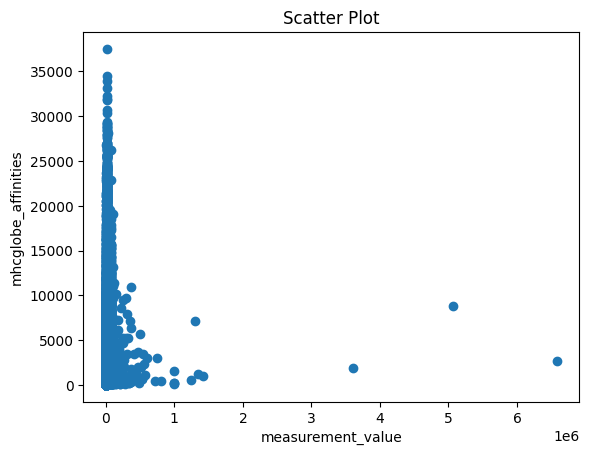

In [35]:
import matplotlib.pyplot as plt

plt.scatter(prediction_df_comparison["measurement_value"], prediction_df_comparison["mhcglobe_affinities"])
plt.xlabel("measurement_value")
plt.ylabel("mhcglobe_affinities")
plt.title('Scatter Plot')
plt.show()

In [36]:
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(prediction_df_comparison["measurement_value"], prediction_df_comparison["mhcglobe_affinities"])
print("R-squared:", r_value**2)

R-squared: 0.02549582272439881


In [37]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(prediction_df_comparison["measurement_value"], prediction_df_comparison["mhcglobe_affinities"])
print("MSE:", mse)

MSE: 862122314.343052


In [38]:
# prompt: AUC prediction_df_comparison

from sklearn import metrics
import numpy as np

auc = metrics.roc_auc_score(prediction_df_comparison["measurement_value"], prediction_df_comparison["mhcglobe_affinities"])
print("AUC:", auc)


ValueError: continuous format is not supported

# Part 2

## Add a fully connected layer (also called linear layer) to the beginning of my tensorflow model so that it can take the larger BERT dimension input





## Retrain the model in 3 above now that you have new features. The retraining in 4 should be with human data.

## Compare performance of the models with one-hot or BERT input. This will give you a clue of your features will help

# Part 3: Hyperparameter Tune with features